# IMPORTING LIBRARIES

In [2]:
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from keras.models import Sequential
import itertools
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

**DEFINING LABELS**

In [110]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

**DEFINING TIME PERIOD AND STEP SIZE**

In [111]:
TIME_PERIODS = 80
STEP_DISTANCE = 40

#We can define time period as the number of steps within one segment
#Step_distance identifies the number of steps to be taken from one segment to the next segment
#If time_periods = step_distance then there is no overlap between the segments


In [153]:
#Defining some standards
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')

**METHOD TO CONVERT TO FLOAT**

In [113]:
def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan

**METHOD TO READ DATA FROM A FILE**

In [114]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

**METHOD TO DISPLAY DATAFRAME INFO**

In [115]:
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# **LOADING WISDM DATASET**

In [116]:
# Load data set containing all the data from csv
df = read_data('/content/drive/MyDrive/wisdm_ar_latest/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')

In [117]:
# Describe the data
show_basic_dataframe_info(df)
df.head(30)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


# PLOTTING INFORMATION

In [118]:
def plot_activity(activity, data):

    fig, (axis_x, axis_y, axis_z) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(axis_x, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(axis_y, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(axis_z, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

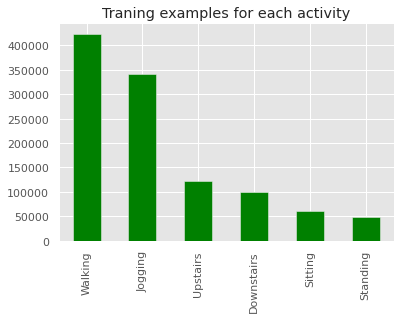

In [119]:
# Number of training examples which exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',color='green',x = 'Activity',y='Training examples',title='Traning examples for each activity')
plt.show()

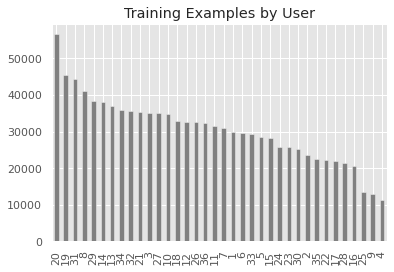

In [120]:
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',color ='gray',
                                  title='Training Examples by User')
plt.show()

**Plotting for each activity**

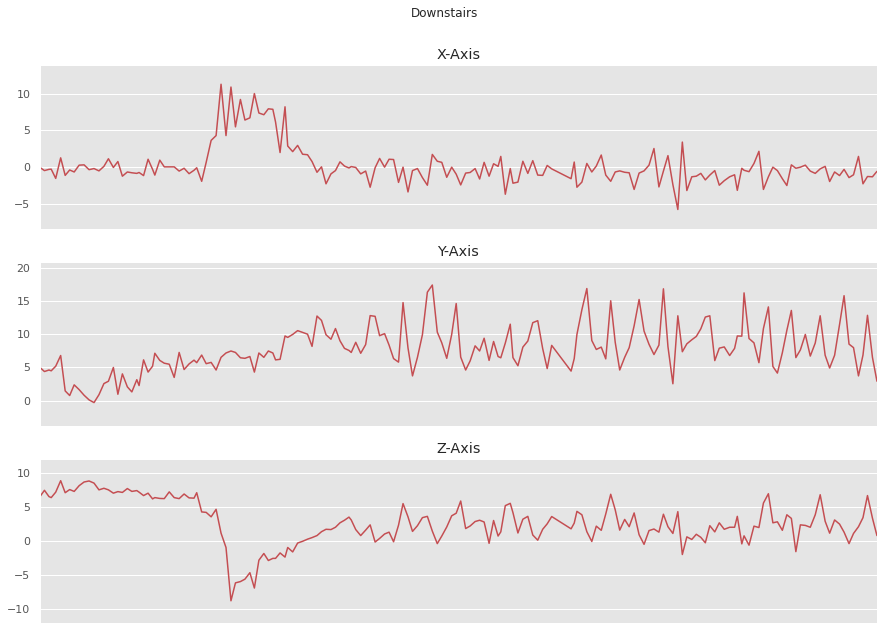

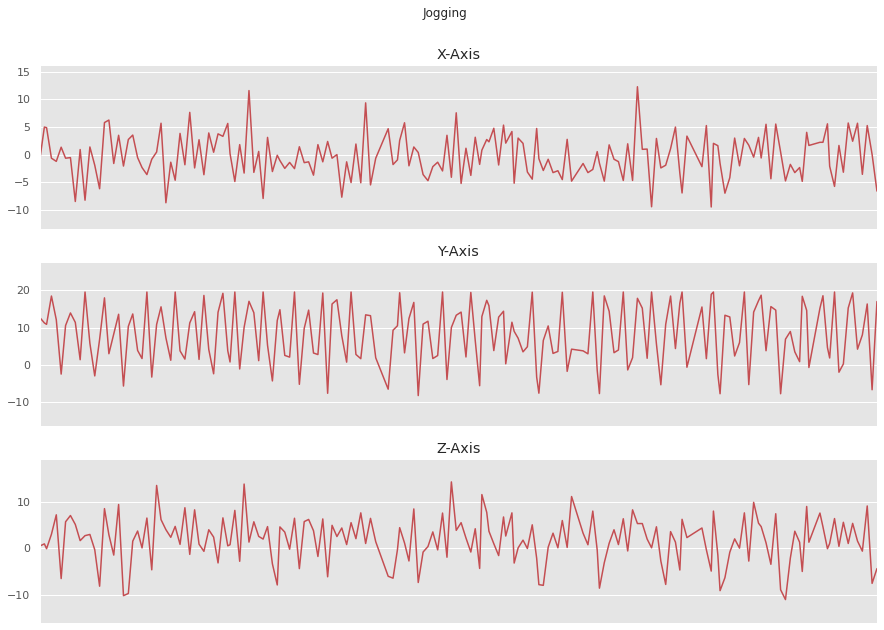

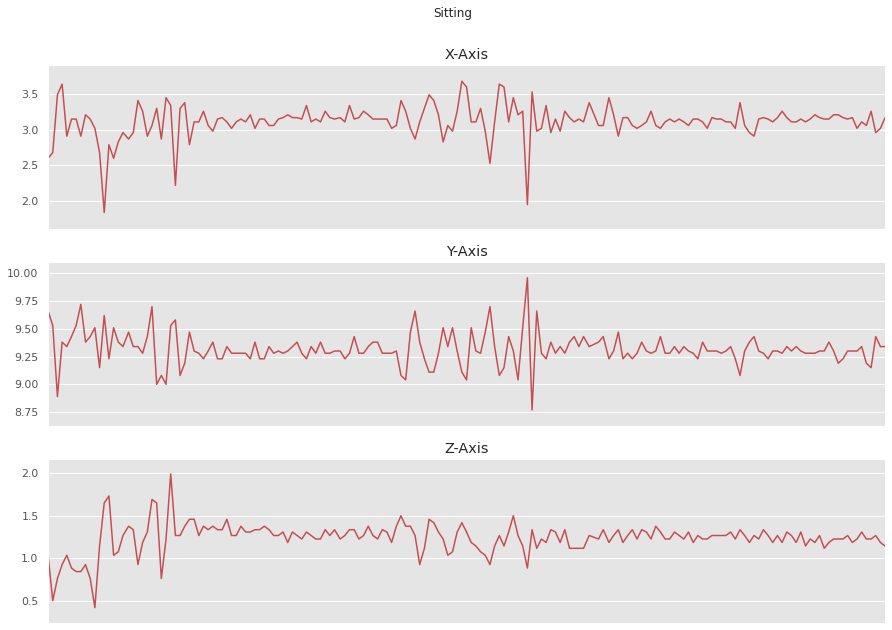

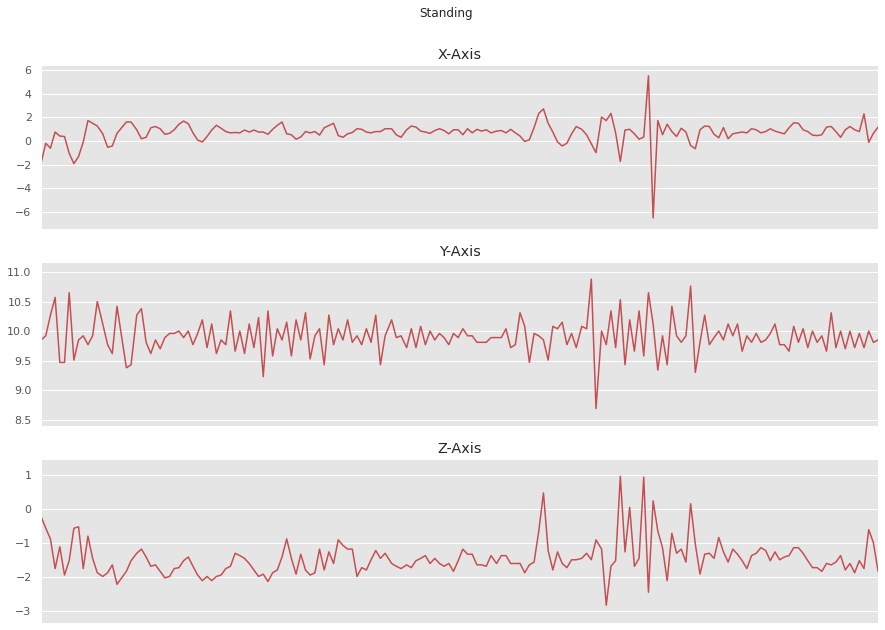

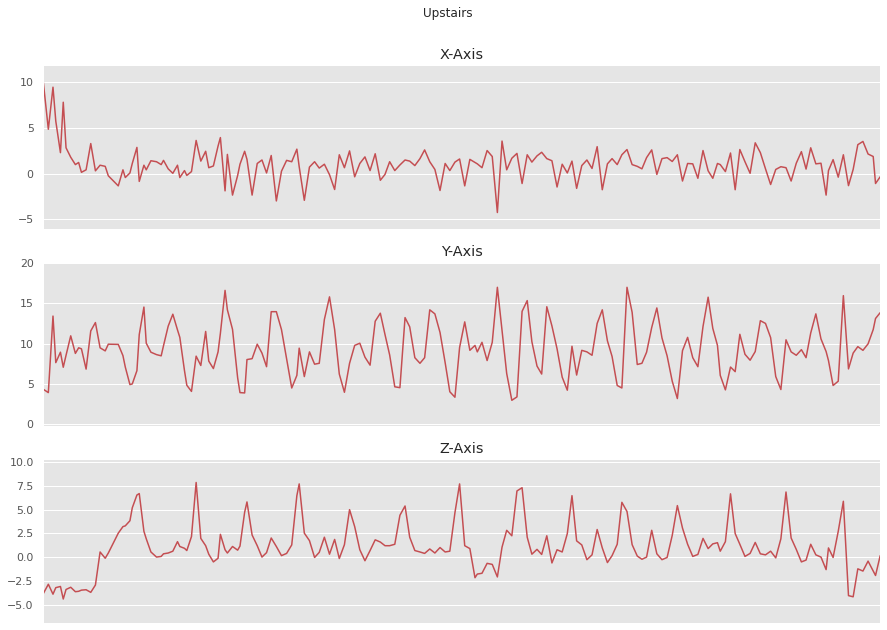

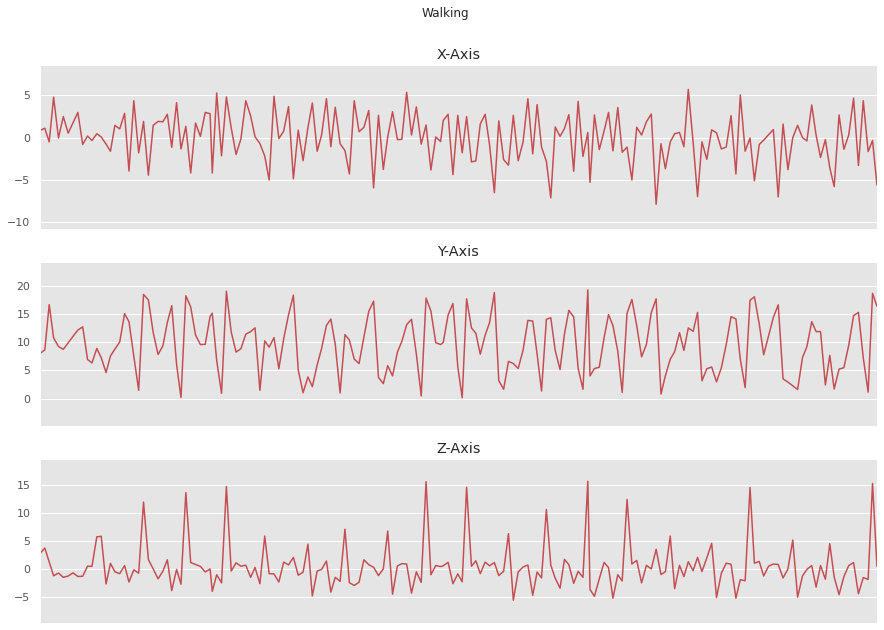

In [121]:
for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

In [122]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

**DATASET SPLITTING**

In [123]:
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

**Normalizing features**

In [124]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [125]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels



In [126]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


In [127]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
x_train shape: (20868, 240)
input_shape: 240


In [128]:
#one hot encoding on train data

y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20868, 6)


In [129]:
# Normalize features for training data set
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = np_utils.to_categorical(y_test, num_classes)

# **MODEL**

# **HYPERPARAMETER TUNING**

In [130]:
batch_size = [512,256]
epoch = [40,50]

In [131]:
max_acc_cnn         = 0
max_valid_acc_cnn   = 0
min_loss            = 0 
min_valid_loss      = 0
best_batch_size     = 0
best_epoch          = 0

for b in batch_size:
  for e in epoch:
    model_m = tf.keras.models.Sequential()
    # Remark: since coreml cannot accept vector shapes of complex shape like
    # [80,3] this workaround is used in order to reshape the vector internally
    # prior feeding it into the network
    model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
    model_m.add(Dense(150, activation='relu'))
    model_m.add(Dropout(0.2))
    model_m.add(Dense(140, activation='relu'))
    model_m.add(Dropout(0.2))
    model_m.add(Dense(130, activation='relu'))
    model_m.add(Dropout(0.2))
    model_m.add(Dense(120, activation='relu'))
    model_m.add(Dropout(0.2))
    model_m.add(Dense(100, activation='relu'))
    model_m.add(Dropout(0.2))
    model_m.add(Dense(80, activation='relu'))
    model_m.add(Flatten())
    model_m.add(Dense(num_classes, activation='softmax'))

    model_m.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam', metrics=['accuracy']) 


    i_model = model_m.fit(x_train, y_train_hot, epochs = e , batch_size = b , validation_split = 0.2 , verbose = 1)

    i_acc_cnn         = np.mean(i_model.history['accuracy'])
    i_valid_acc_cnn   = np.mean(i_model.history['val_accuracy'])
    i_loss            = np.mean(i_model.history['loss'])
    i_valid_loss      = np.mean(i_model.history['val_loss'])

    if(i_valid_acc_cnn > max_valid_acc_cnn):
      if(min_valid_loss < i_valid_loss):
        max_acc_cnn         = i_acc_cnn
        max_valid_acc_cnn   = i_valid_acc_cnn
        min_loss            = i_loss
        min_valid_loss      = i_valid_loss
        best_batch_size     = b
        best_epoch  = e

Epoch 1/40
33/33 [==============================] - 3s 63ms/step - loss: 1.2704 - accuracy: 0.4978 - val_loss: 0.7653 - val_accuracy: 0.7563
Epoch 2/40
33/33 [==============================] - 2s 51ms/step - loss: 0.6770 - accuracy: 0.7540 - val_loss: 0.6778 - val_accuracy: 0.8019
Epoch 3/40
33/33 [==============================] - 2s 51ms/step - loss: 0.5587 - accuracy: 0.7902 - val_loss: 0.6595 - val_accuracy: 0.8052
Epoch 4/40
33/33 [==============================] - 2s 50ms/step - loss: 0.5295 - accuracy: 0.8044 - val_loss: 0.6592 - val_accuracy: 0.8093
Epoch 5/40
33/33 [==============================] - 2s 51ms/step - loss: 0.5145 - accuracy: 0.8119 - val_loss: 0.6809 - val_accuracy: 0.7849
Epoch 6/40
33/33 [==============================] - 2s 50ms/step - loss: 0.4854 - accuracy: 0.8218 - val_loss: 0.6967 - val_accuracy: 0.7743
Epoch 7/40
33/33 [==============================] - 2s 50ms/step - loss: 0.4620 - accuracy: 0.8294 - val_loss: 0.7590 - val_accuracy: 0.7499
Epoch 8/40
33

In [132]:
print("maximum accuracy = ",max_acc_cnn)
print("\n maximum accuracy on validation data = ",max_valid_acc_cnn)
print("\n minimum loss = ",min_loss) 
print("\n minimum loss on validation data =",min_valid_loss)
print("\n batch size = ",best_batch_size)
print("\n total epochs = ",best_epoch)

maximum accuracy =  0.8732862079143524

 maximum accuracy on validation data =  0.7388643991947174

 minimum loss =  0.3357993376255035

 minimum loss on validation data = 0.8338138473033905

 batch size =  512

 total epochs =  50


# **CREATING MODEL WITH BATCH SIZE = 512 , EPOCH = 50**

In [143]:
model = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(140, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(130, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(80, activation='relu'))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_31 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
dense_217 (Dense)            (None, 80, 150)           600       
_________________________________________________________________
dropout_155 (Dropout)        (None, 80, 150)           0         
_________________________________________________________________
dense_218 (Dense)            (None, 80, 140)           21140     
_________________________________________________________________
dropout_156 (Dropout)        (None, 80, 140)           0         
_________________________________________________________________
dense_219 (Dense)            (None, 80, 130)           18330     
_________________________________________________________________
dropout_157 (Dropout)        (None, 80, 130)          

In [144]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 512
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
33/33 [==============================] - 4s 85ms/step - loss: 1.4737 - accuracy: 0.4180 - val_loss: 0.7415 - val_accuracy: 0.7647
Epoch 2/50
33/33 [==============================] - 2s 51ms/step - loss: 0.7259 - accuracy: 0.7384 - val_loss: 0.6789 - val_accuracy: 0.8067
Epoch 3/50
33/33 [==============================] - 2s 51ms/step - loss: 0.5768 - accuracy: 0.7893 - val_loss: 0.6881 - val_accuracy: 0.7877
Epoch 4/50
33/33 [==============================] - 2s 51ms/step - loss: 0.5501 - accuracy: 0.7966 - val_loss: 0.7159 - val_accuracy: 0.7662
Epoch 5/50
33/33 [==============================] - 2s 51ms/step - loss: 0.5186 - accuracy: 0.8096 - val_loss: 0.6975 - val_accuracy: 0.7729
Epoch 6/50
33/33 [==============================] - 2s 51ms/step - loss: 0.5128 - accuracy: 0.8088 - val_loss: 0.6605 - val_accuracy: 0.7992
Epoch 7/50
33/33 [==============================] - 2s 50ms/step - loss: 0.4613 - accuracy: 0.8348 - val_loss: 0.6862 - val_accuracy: 0.7698
Epoch 8/50
33

# **PLOTTING ACCURACY VS EPOCH**

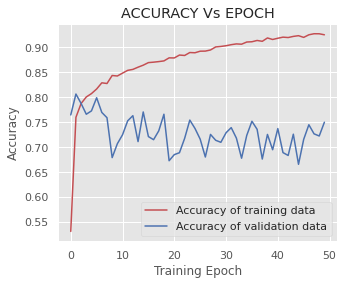

In [154]:
plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], 'r-', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b-', label='Accuracy of validation data')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.title('ACCURACY Vs EPOCH')
plt.legend()
plt.show()

# **PLOTTING LOSS VS EPOCH**

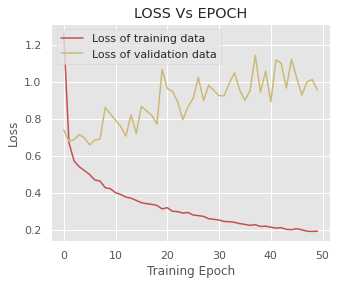

In [155]:
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], 'r-', label='Loss of training data')
plt.plot(history.history['val_loss'], 'y-', label='Loss of validation data')
plt.title('LOSS Vs EPOCH')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.legend()
plt.show()

# **PREDICTING LABELS FOR TEST DATA USING TRAINED MODEL**

In [156]:
y_pred_train = model.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

              precision    recall  f1-score   support

         0.0       0.66      0.76      0.71      1864
         1.0       0.99      0.96      0.98      6567
         2.0       1.00      1.00      1.00      1050
         3.0       0.99      0.99      0.99       833
         4.0       0.76      0.64      0.70      2342
         5.0       0.91      0.94      0.92      8212

    accuracy                           0.90     20868
   macro avg       0.88      0.88      0.88     20868
weighted avg       0.90      0.90      0.90     20868



# **CALCULATING ACCURACY OF PREDICTION**

In [157]:
score = model_m.evaluate(x_test, y_test, verbose=1)
accuracy_test = score[1] * 100

print('\nLoss on test data: %0.2f' % score[0])
print("\n ACCURACY ON TEST DATA = ", accuracy_test,"%")

206/206 [==============================] - 1s 6ms/step - loss: 1.9659 - accuracy: 0.7685

Loss on test data: 1.97

 ACCURACY ON TEST DATA =  76.85297727584839 %


# **PLOTTING CONFUSION MATRIX**

In [158]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='Greens',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [159]:
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

In [160]:
print(classification_report(max_y_test, max_y_pred_test))

              precision    recall  f1-score   support

           0       0.58      0.57      0.57       650
           1       0.78      0.93      0.85      1990
           2       0.84      1.00      0.91       452
           3       0.95      0.79      0.86       370
           4       0.55      0.39      0.46       725
           5       0.82      0.76      0.79      2397

    accuracy                           0.77      6584
   macro avg       0.75      0.74      0.74      6584
weighted avg       0.76      0.77      0.76      6584



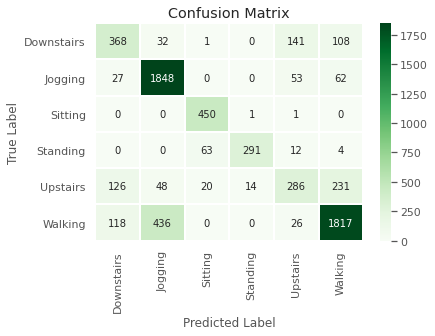

In [161]:
show_confusion_matrix(max_y_test, max_y_pred_test)